In [224]:
from pathlib import Path
import pandas as pd
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
import matplotlib.pyplot as plt
import numpy as np

In [225]:
bag_path = Path('dist_bearing_bag')
topics = [
    '/bearing_dist/bearing',
    '/bearing_dist/dist',
    '/bearing_dist/bearing_error',
    '/bearing_dist/dist_error'
]

typestore = get_typestore(Stores.ROS2_HUMBLE) 

records = {topic: {'time': [], 'value': []} for topic in topics}

with AnyReader([bag_path], default_typestore=typestore) as reader:
    print("Available topics:")
    for conn in reader.connections:
        print(f"  {conn.topic} ({conn.msgtype})")

    for conn, timestamp, rawdata in reader.messages():
        if conn.topic in topics:
            msg = reader.deserialize(rawdata, conn.msgtype)
            records[conn.topic]['time'].append(timestamp * 1e-9)  # convert ns → s
            records[conn.topic]['value'].append(msg.data)

dfs = [pd.DataFrame({'time': records[t]['time'], t: records[t]['value']}) for t in topics]

# Merge all DataFrames on nearest timestamp
df_merged = dfs[0].sort_values('time')
for df in dfs[1:]:
    df_merged = pd.merge_asof(df_merged, df.sort_values('time'), on='time', direction='nearest')

df_merged = df_merged.sort_values('time').reset_index(drop=True)

print(df_merged.head())


Available topics:
  /bearing_dist/dist_error (std_msgs/msg/Float32)
  /bearing_dist/dist (std_msgs/msg/Float32)
  /bearing_dist/bearing_error (std_msgs/msg/Float32)
  /bearing_dist/bearing (std_msgs/msg/Float32)
           time  /bearing_dist/bearing  /bearing_dist/dist  \
0  1.762551e+09                0.18086            1.595452   
1  1.762551e+09                0.18086            1.595452   
2  1.762551e+09                0.18086            1.595452   
3  1.762551e+09                0.18086            1.595452   
4  1.762551e+09                0.18086            1.595452   

   /bearing_dist/bearing_error  /bearing_dist/dist_error  
0                     0.002812                  0.074111  
1                     0.002812                  0.074111  
2                     0.002811                  0.074107  
3                     0.002811                  0.074103  
4                     0.002811                  0.074099  


In [226]:
t = 0 ## skip measurements when setting up robot

d_measured = df_merged['/bearing_dist/dist'][t:]
d_error = (df_merged['/bearing_dist/dist_error'][t:] - 0.1)**2 ## offset cylinder radius
theta_measured = df_merged['/bearing_dist/bearing'][t:]
theta_error = df_merged['/bearing_dist/bearing_error'][t:]**2

change_theta = np.gradient(theta_measured)

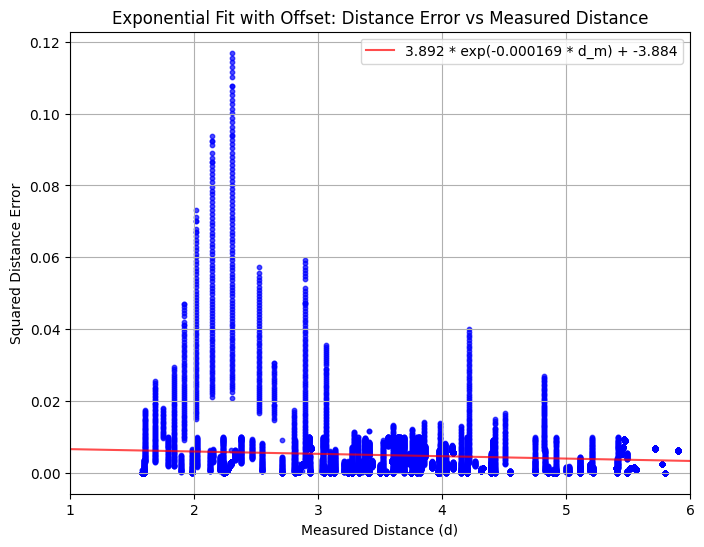

In [ ]:
from scipy.optimize import curve_fit

def exp_with_offset(x, a, b, c):
    return a * np.exp(b * x) + c

p0 = [1.0, 0.1, 0.0]
params, cov = curve_fit(exp_with_offset, d_measured, d_error, p0=p0)
a, b, c = params

# Generate smooth curve for plotting
ds = np.linspace(0, 10, 1000)
y_fit = exp_with_offset(ds, a, b, c)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(ds, y_fit, color='red', alpha=0.7,
         label=f'{round(a,3)} * exp({round(b,7)} * d_m) + {round(c,3)}')
plt.scatter(d_measured, d_error, s=10, alpha=0.7, color='blue')
plt.title('Exponential Fit with Offset: Distance Error vs Measured Distance')
plt.xlim(1, 6)
plt.xlabel('Measured Distance (d)')
plt.ylabel('Squared Distance Error')
plt.grid(True)
plt.legend()
plt.show()


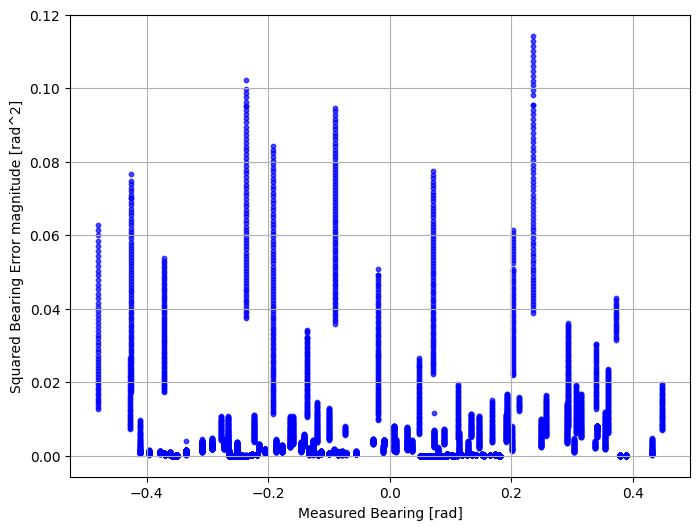

In [228]:
plt.figure(figsize=(8, 6))
plt.scatter(theta_measured, theta_error, s=10, alpha=0.7, color='blue')
plt.ylabel('Squared Bearing Error magnitude [rad^2]')
plt.xlabel('Measured Bearing [rad]')
plt.grid(True)
plt.show()

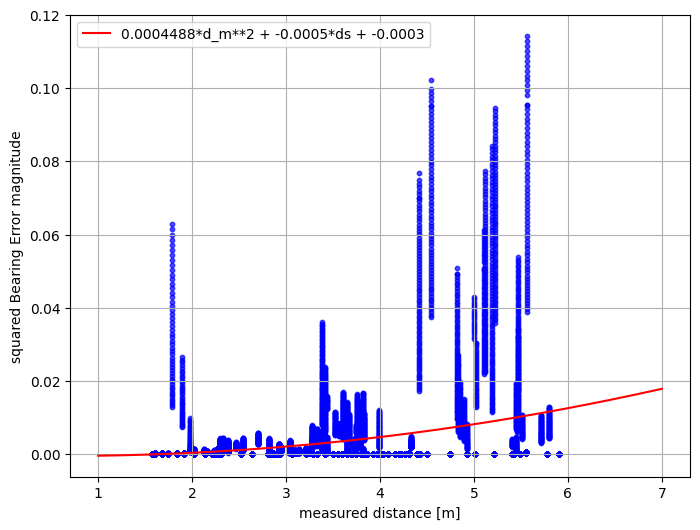

In [234]:
A = np.ones((len(d_measured), 3))
A[:, 0] = d_measured**2
A[:, 1] = d_measured
a, b, c = np.linalg.solve(A.T@A, A.T@theta_error)

ds = np.linspace(1,7, 1000)

plt.figure(figsize=(8, 6))
plt.plot(ds, a*ds**2 + b*ds + c, color='red', label = f'{round(a,7)}*d_m**2 + {round(b,4)}*ds + {round(c,4)}')
plt.scatter(d_measured, theta_error, s=10, alpha=0.7, color='blue')
plt.ylabel('squared Bearing Error magnitude')
plt.xlabel('measured distance [m]')
plt.legend()
plt.grid(True)
plt.show()